##### Disclaimer
Este trabalho foi baseado no tutorial sobre séries temporais do TensorFlow (https://www.tensorflow.org/tutorials/structured_data/time_series) e no capítulo 10 do livro "*Deep Learning With Python 2ed*", adaptando ao caso de uso de análise da série temporal do petróleo Brent.

No entanto, é importante fazermos uma ressalva, no próprio livro o autor ressalta que, quando se trata de mercado financeiro, desempenhos passados *não* são um bom preditor para ganhos futuros, ou como o próprio autor coloca, dirigir olhando para o retrovisor é uma péssima forma de dirigir.

# Tech Challenge Fase 4
## Prevendo os valores futuros do petróleo Brent
Membros do grupo 24:

- RM351388 - Carolina Pasianot Casetta - carol_pasianot@hotmail.com
- RM351418 - Gustavo França Severino - gustavofs.dt@gmail.com
- RM352372 - Frederico Garcia Costa - fredgcosta@gmail.com
- RM351905 - Jeferson Vieira - jvieirax@gmail.com
- Victor Wilson Costa Lamana - victor.lamana15@gmail.com

Neste notebook iremos realizar uma análise da série temporal do petróleo Brent e propor uma estratégia para a previsão dos valores futuros. Iremos utilizar as bibliotecas TensorFlow e Keras para a criação dos modelos.

## Importando as bibliotecas necessárias

In [21]:
import os
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
keras = tf.keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

%matplotlib inline
mpl.rcParams['figure.figsize'] = (20, 6)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['font.size'] = 12

In [22]:
print("Quantidade de GPUs disponíveis: ", len(tf.config.list_physical_devices('GPU')))

Quantidade de GPUs disponíveis:  1


## Obtendo os Dados do petróleo Brent

Utilizamos duas fontes para obter os dados históricos do petróleo brent:
    1. Dados do site EIA (Energy Information Administration) https://www.eia.gov/dnav/pet/hist/RBRTED.htm
    2. Biblioteca yfinance para obter os dados mais recentes, utilizando o código BZ=F.

Com isso obtivemos o intervalo de 20/05/1987 até 19/05/2024.

In [23]:
brent = pd.read_csv('Europe_Brent_Spot_Price_FOB.csv', parse_dates=True, index_col=0)
brent = brent.sort_values(by='Date', ascending=True)
brent.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9384 entries, 1987-05-20 to 2024-05-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   9384 non-null   float64
dtypes: float64(1)
memory usage: 146.6 KB


In [24]:
brent.head()

,Close
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [25]:
import yfinance as yf
yf.pdr_override()
yf.set_tz_cache_location(".cache/py-yfinance")

# Especifique o símbolo do petróleo Brent (BZ=F) e o intervalo de datas desejado
symbol = 'BZ=F'
start_date = '2024-05-14'

# Use a função download para obter os dados
yf_brent = yf.download(symbol, start=start_date)
yf_brent = yf_brent.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']) # Removendo colunas desnecessárias
yf_brent = yf_brent.sort_values(by='Date', ascending=True)
yf_brent.info()

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5 entries, 2024-05-14 to 2024-05-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   5 non-null      float64
dtypes: float64(1)
memory usage: 80.0 bytes


In [26]:
yf_brent.head()

,Close
Date,
2024-05-14,82.379997
2024-05-15,82.750000
2024-05-16,83.269997
2024-05-17,83.980003
2024-05-20,84.349998


In [27]:
brent = pd.concat([brent,yf_brent])

In [28]:
brent.tail(10)

,Close
Date,
2024-05-07,82.690000
2024-05-08,82.440000
2024-05-09,83.270000
2024-05-10,83.390000
2024-05-13,83.180000
2024-05-14,82.379997
2024-05-15,82.750000
2024-05-16,83.269997
2024-05-17,83.980003


In [29]:
brent['Log Returns'] = np.log(brent['Close']/brent['Close'].shift(1)).dropna()

Agora vamos verificar a evolução do Fechamento e do Volume ao longo do tempo

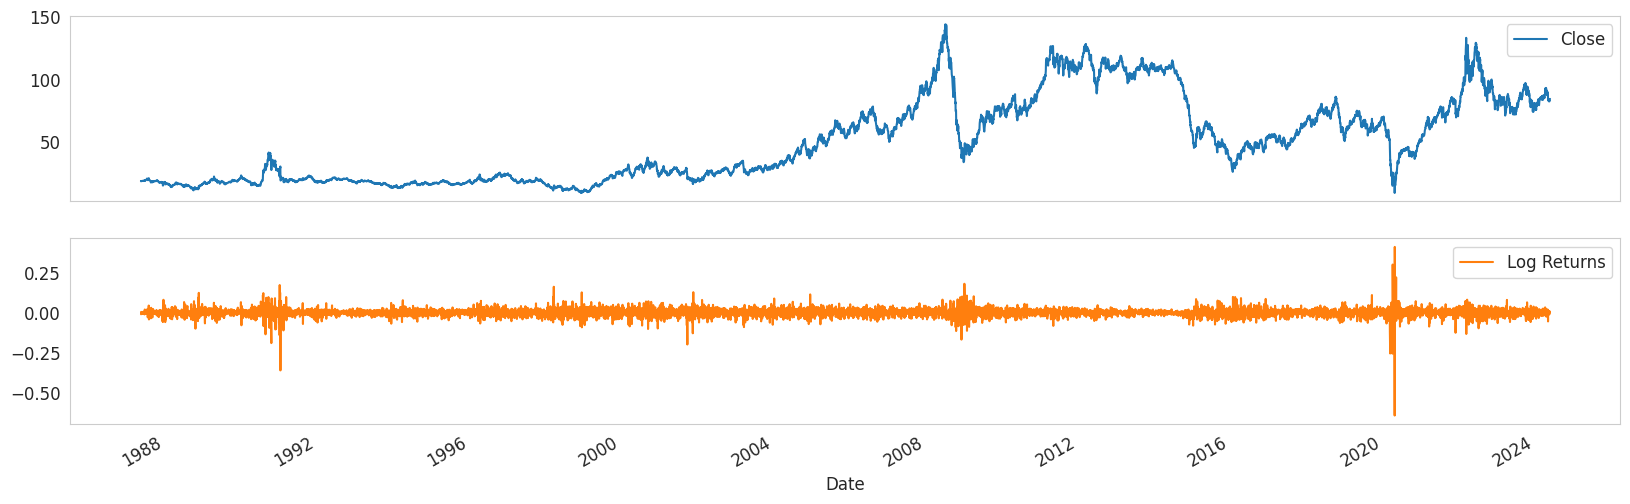

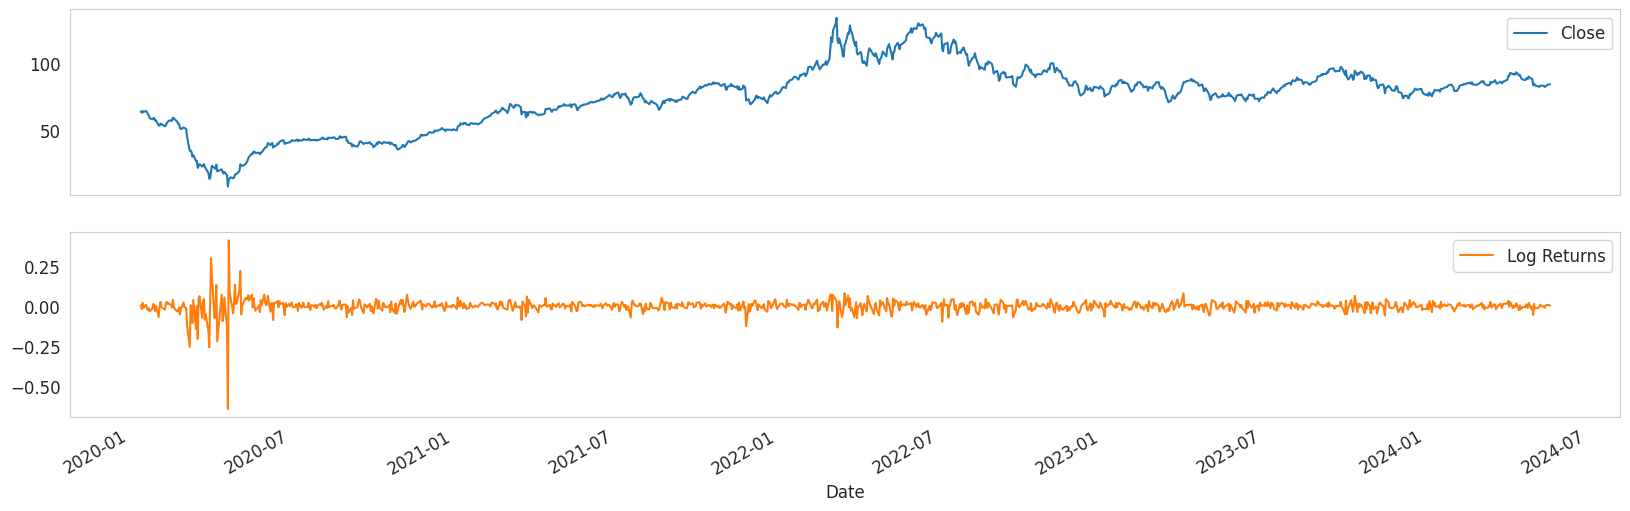

In [30]:
plot_cols = ['Close', 'Log Returns']
plot_features = brent[plot_cols]
plot_features.index = brent.index
_ = plot_features.plot(subplots=True)

plot_features = brent[plot_cols][-1100:]
plot_features.index = brent.index[-1100:]
_ = plot_features.plot(subplots=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9389 entries, 1987-05-20 to 2024-05-20
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close        9389 non-null   float64
 1   Log Returns  9388 non-null   float64
dtypes: float64(2)
memory usage: 220.1 KB
Quantidade de linhas e colunas: (9389, 2)
Quantidade de valores nulos: 1


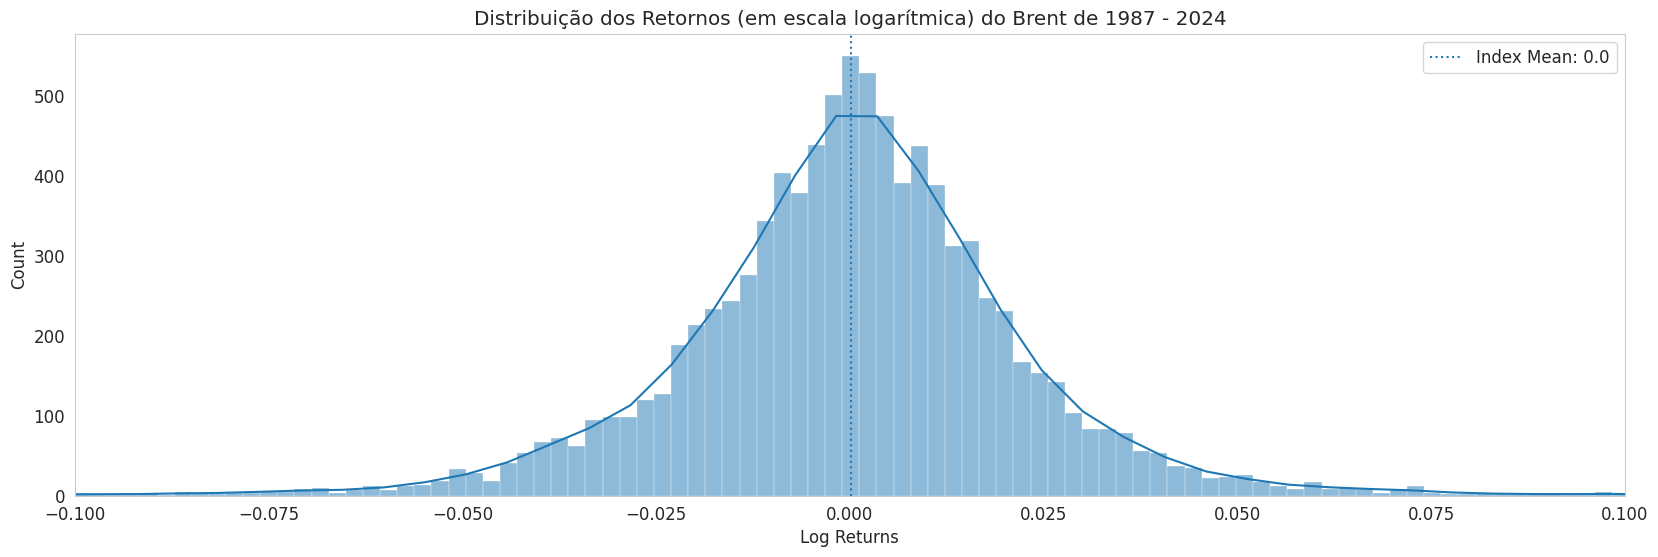

In [31]:
ax = sns.histplot(brent['Log Returns'], kde=True)
mean_return = brent['Log Returns'].mean()
plt.title('Distribuição dos Retornos (em escala logarítmica) do Brent de 1987 - 2024')
plt.axvline(mean_return, ls=':', label='Index Mean: {}'.format(round(mean_return, 2)))
plt.legend();
ax = ax.set_xlim(-.1,.1)
brent.info()
print('Quantidade de linhas e colunas:', brent.shape)
print('Quantidade de valores nulos:', brent.isna().sum().sum())

Verificando as estatísticas do conjunto de dados

In [32]:
brent.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close,9389.0,49.818249,32.927230,9.100000,19.270000,42.470000,73.870000,143.950000
Log Returns,9388.0,0.000161,0.025345,-0.643699,-0.011164,0.000455,0.012151,0.412023


Para esse estudo, vamos descartar os valores de Abertura, Máxima, Mínima e de Volume. Iremos considerar apenas os valores de Fechamento ('Close'). 

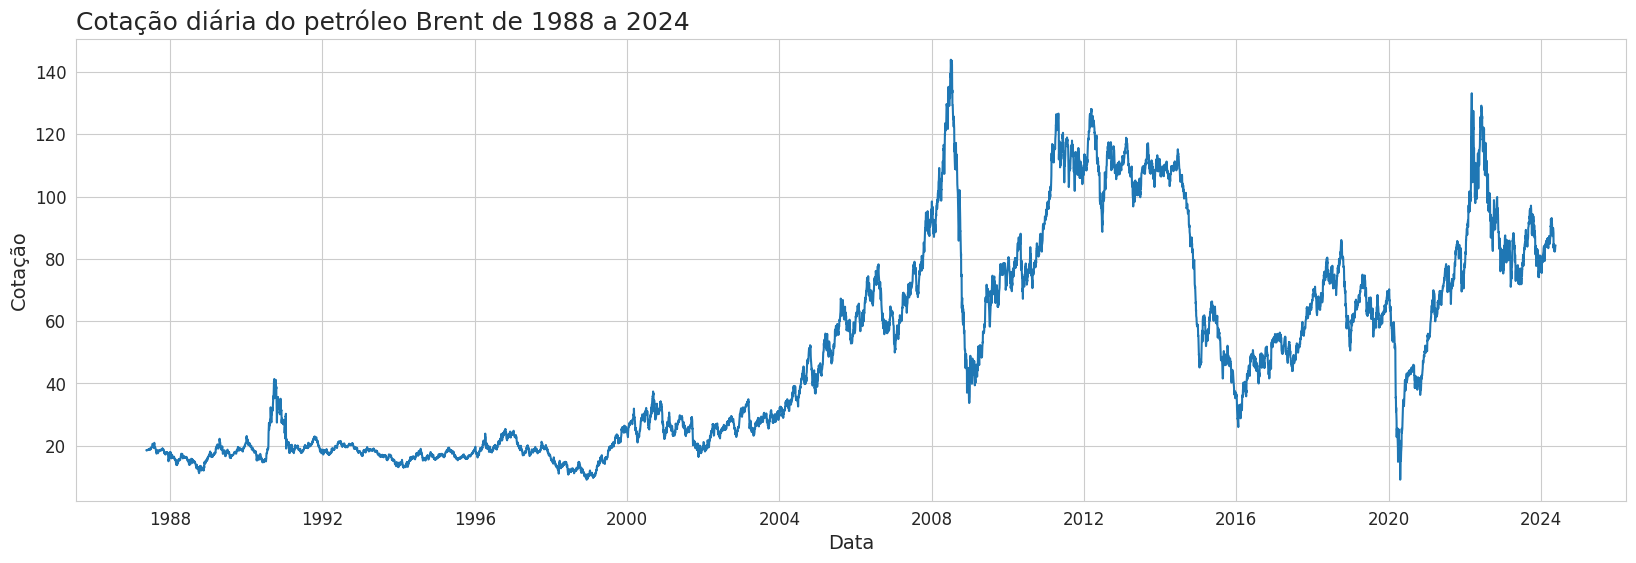

In [33]:
sns.set_palette('tab10')
sns.set_style('whitegrid')
ax = sns.lineplot(brent['Close'])
ax.set_title('Cotação diária do petróleo Brent de 1988 a 2024', loc='left', fontsize=18)
ax.set_xlabel('Data', fontsize=14)
ax.set_ylabel('Cotação', fontsize=14)
ax = ax

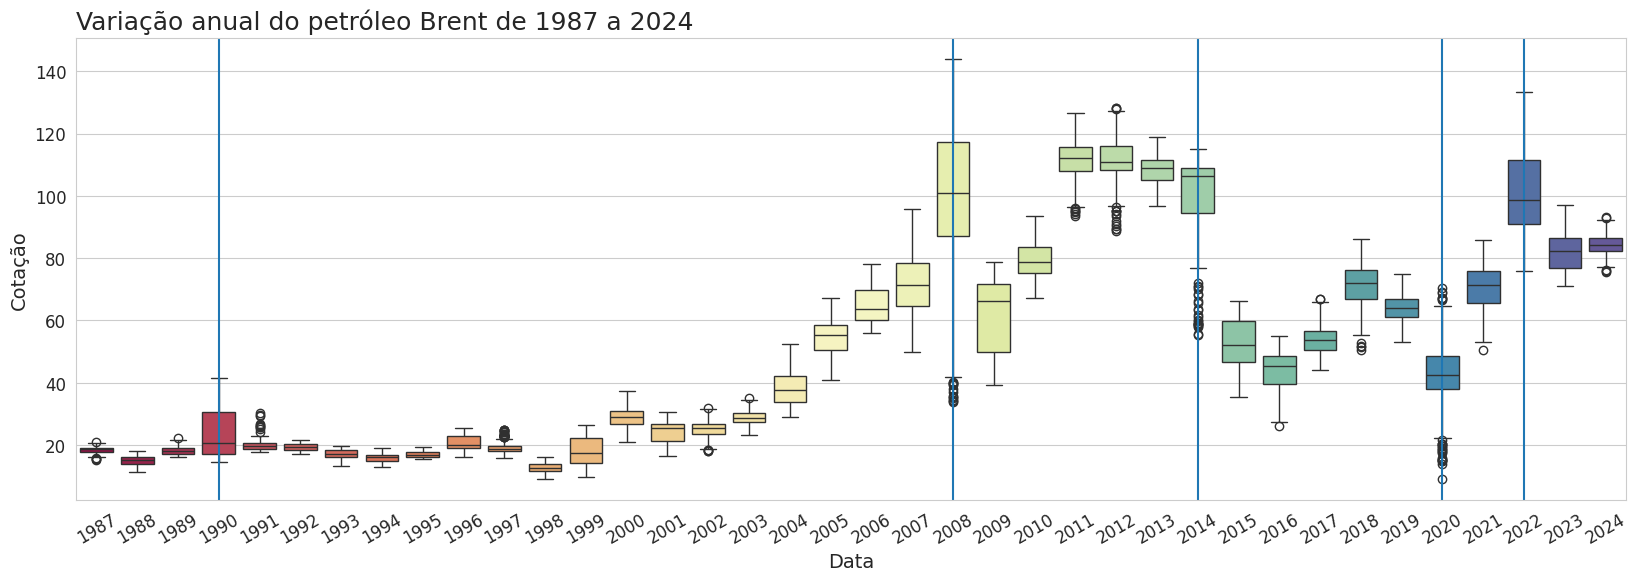

In [34]:
sns.set_palette('tab10')
sns.set_style('whitegrid')
ax = sns.boxplot(x=brent.index.year, hue=brent.index.year, y=brent['Close'], palette='Spectral', legend=False)
ax.set_title('Variação anual do petróleo Brent de 1987 a 2024', loc='left', fontsize=18)
ax.set_xlabel('Data', fontsize=14)
ax.set_ylabel('Cotação', fontsize=14)
ax.tick_params(axis='x', labelrotation=30)
ax.axvline('1990')
ax.axvline('2008')
ax.axvline('2014')
ax.axvline('2020')
ax.axvline('2022')
ax = ax

Do boxplot acima, podemos observar uma volatilidade anormal principalmente nos anos de 1990, 2008, 2014, 2020 e 2022. As principais razões para essas anomalias estão listadas abaixo:

1990: Guerra do Golfo e inverno rigoroso.

2008: Crise financeira (A Grande Recessão).

2014: Preocupações geopolíticas reduzidas e oferta constante de petróleo pela OPEC.

2020: Pandemia de Covid-19 e restrições de viagem.

2022: Guerra entre Rússia e Ucrânia.

Esses eventos mencionados acima são frequentemente considerados anomalias, tornando a série altamente volátil e imprevisível, já que a maioria dos modelos assume que os dados são homocedásticos (ou seja, a média e a variância permanecem constantes ao longo do tempo).

## Agora vamos fazer uma análise mais profunda usando Redes Neurais

In [35]:
df = brent.copy(deep=True)
dti = df.index
# df['Timestamp'] = dti.map(pd.Timestamp.timestamp)
df = df.drop(columns=['Log Returns']) # Removendo colunas desnecessárias
# df = df.loc['2020-01-02':]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9389 entries, 1987-05-20 to 2024-05-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   9389 non-null   float64
dtypes: float64(1)
memory usage: 146.7 KB


### Dividindo os dados em Treinamento, Validação e Teste

Iremos usar uma divisão (70%, 20%, 10%) para as amostras de treinamento, validação e teste. Observe que os dados não estão sendo embaralhados de forma aleatória antes da divisão. Isso por dois motivos:

1. Garante que seja possível separar os dados em janelas de amostras consecutivas.
2. Garante que os resultados da validação/teste sejam mais realistas, sendo avaliados nos dados coletados após o treinamento do modelo.

In [36]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [37]:
x = df[-30:]
x

,Close
Date,
2024-04-08,91.730000
2024-04-09,92.130000
2024-04-10,91.570000
2024-04-11,91.490000
2024-04-12,93.120000
2024-04-15,90.840000
2024-04-16,91.290000
2024-04-17,89.540000
2024-04-18,88.340000


### Normalizando os Dados
É importante que a gente escale os dados antes de treinar a rede neural. A normalização é uma forma de colocar os dados na mesma escala: subtraindo a média e dividindo pelo desvio padrão.

A média e o desvio padrão devem ser calculados usando-se apenas os dados de treinamento para que os modelos não tenham acesso aos valores das amostras de validação e de testes (*data leaking*).

In [38]:
def standardize_data(train_df, val_df, test_df):
    train_mean = train_df.mean()
    train_std = train_df.std()
    
    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    len_train_df = len(train_df)
    len_val_df = len(val_df)
    len_test_df = len(test_df)
    return train_df, val_df, test_df

In [43]:
def unstandardize_data(train_df, s_train_df, s_val_df, s_test_df):
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df =   (s_train_df * train_std) + train_mean
    val_df = (s_val_df * train_std) + train_mean
    test_df = (s_test_df * train_std) + train_mean

    return train_df, val_df, test_df

In [44]:
s_train_df, s_val_df, s_test_df = standardize_data(train_df, val_df, test_df)
u_train_df, u_val_df, u_test_df = unstandardize_data(train_df, s_train_df, s_val_df, s_test_df)

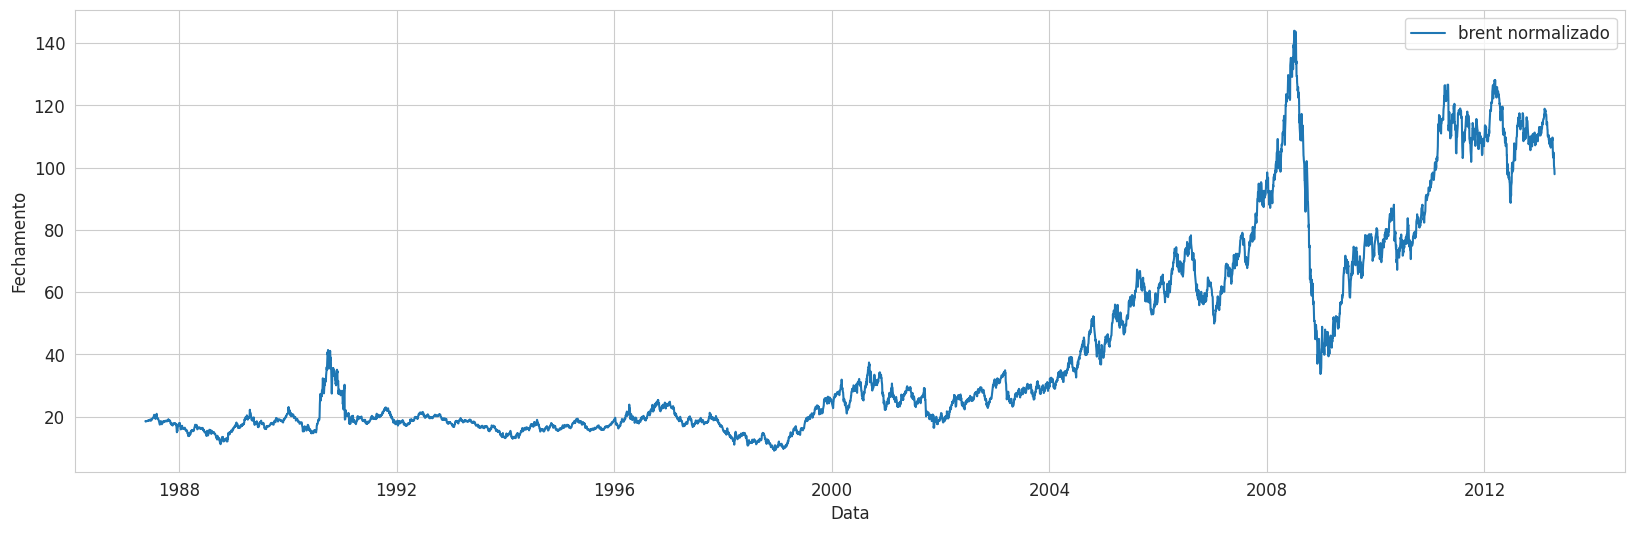

In [45]:
sns.lineplot(x='Date',y='Close', data=u_train_df, label='brent normalizado')
plt.ylabel('Fechamento')
_ = plt.xlabel('Data')

<Axes: xlabel='Date', ylabel='Close'>

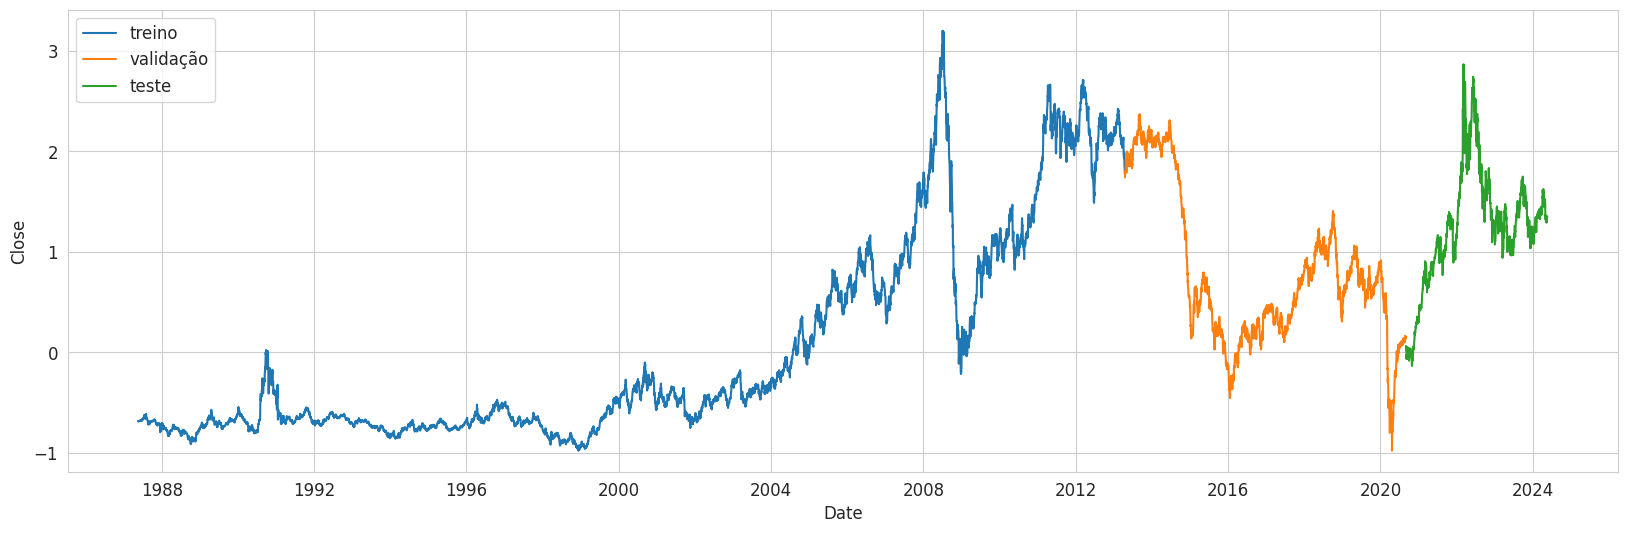

In [47]:
sns.lineplot(x='Date',y='Close', data=s_train_df, label='treino')
sns.lineplot(x='Date',y='Close', data=s_val_df, label='validação')
sns.lineplot(x='Date',y='Close', data=s_test_df, label='teste')

In [20]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [21]:
x_train = np.array(s_train_df['Close'], dtype=np.float32)
x_train = tf.constant(x_train)
x_valid = np.array(s_val_df['Close'], dtype=np.float32)
x_valid = tf.constant(x_valid)
x_test = np.array(s_test_df['Close'], dtype=np.float32)
x_test = tf.constant(x_test)

In [22]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        if(model.name != 'sequential'):
            self.model.reset_states()

In [23]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
    keras.Input(batch_shape=[1, None, 1]),
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-9 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(learning_rate=1e-9, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanSquaredError()])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule, reset_states])

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 7.4160 - mean_absolute_error: 7.9149 - mean_squared_error: 68.8192 - learning_rate: 1.0000e-09
Epoch 2/100
  9/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.5159 - mean_absolute_error: 8.0147 - mean_squared_error: 70.6149

/home/fredg/miniconda3/envs/tensorflow/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 7.1885 - mean_absolute_error: 7.6873 - mean_squared_error: 65.3278 - learning_rate: 1.1220e-09
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 6.8641 - mean_absolute_error: 7.3626 - mean_squared_error: 60.2134 - learning_rate: 1.2589e-09
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 6.5019 - mean_absolute_error: 6.9999 - mean_squared_error: 54.7637 - learning_rate: 1.4125e-09
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 6.0978 - mean_absolute_error: 6.5948 - mean_squared_error: 49.0079 - learning_rate: 1.5849e-09
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 5.6474 - mean_absolute_error: 6.1443 - mean_squared_error: 42.9960 - learning_rate: 1.7783e-09
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 5.1464 - mean_absolute_error: 5.6434 - mean_squared_error: 36.8061 - learning_rate: 1.9953e-09
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 4.5918 -

(1e-09, 0.0001, 0.0, 10.0)

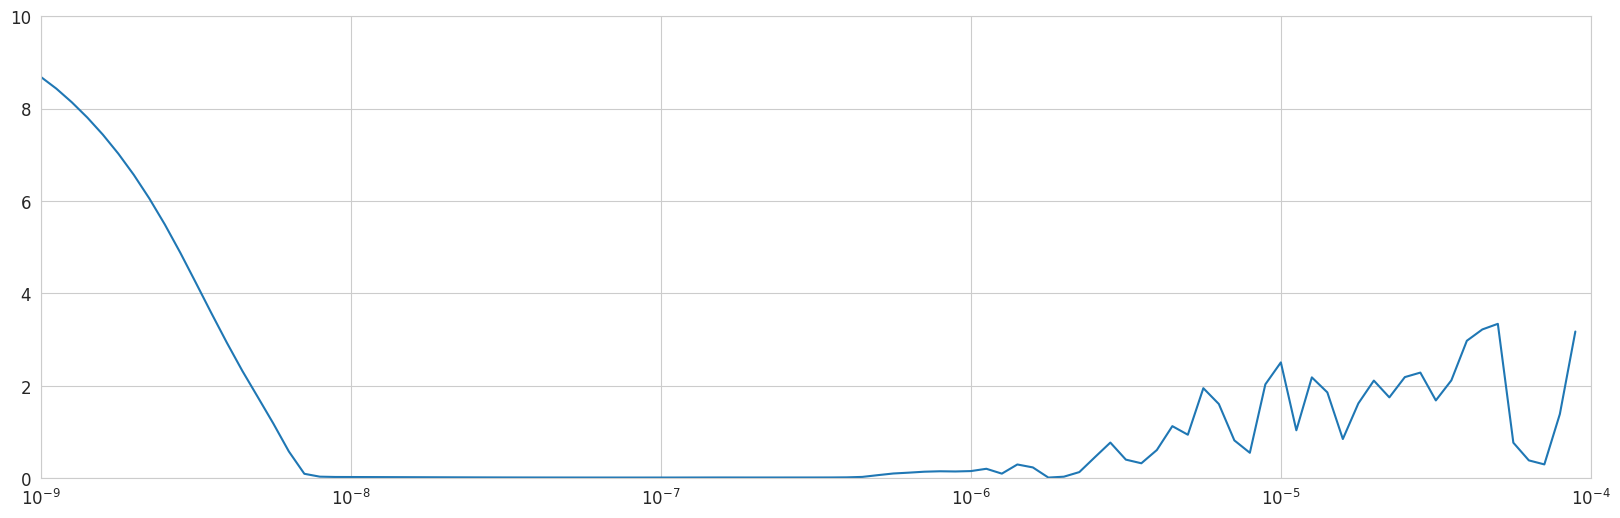

In [24]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-9, 1e-4, 0, 10])

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.Input(batch_shape=[1, None, 1]),
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(learning_rate=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanSquaredError()])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "lstm_model.keras", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.1522 - mean_absolute_error: 0.2964 - mean_squared_error: 0.8652 - val_loss: 1.0062 - val_mean_absolute_error: 1.4481 - val_mean_squared_error: 2.9803
Epoch 2/500
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 1.1385 - mean_absolute_error: 1.4922 - mean_squared_error: 5.4283 - val_loss: 1.0637 - val_mean_absolute_error: 1.5156 - val_mean_squared_error: 3.6821
Epoch 3/500
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 1.3673 - mean_absolute_error: 1.7237 - mean_squared_error: 7.4228 - val_loss: 1.4386 - val_mean_absolute_error: 1.9348 - val_mean_squared_error: 5.0430
Epoch 4/500
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 1.4444 - mean_absolute_error: 1.8390 - mean_squared_error: 7.6718 - val_loss: 0.8846 - val_mean_absolute_error: 1.3097 - val_mean_squared_error: 3.1037
Epoch 5/500
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 1.2806 - mean_absolute_error: 1.6606 - mean_squared_error: 6.4322 - val_loss: 0.89

In [26]:
model = keras.models.load_model("lstm_model.keras", safe_mode=False)

In [27]:
val_array = np.array(s_val_df['Close'], dtype=np.float32)
val_rnn_forecast = model.predict(val_array[np.newaxis, :, np.newaxis])
val_rnn_forecast = val_rnn_forecast[0, :len(val_array), 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


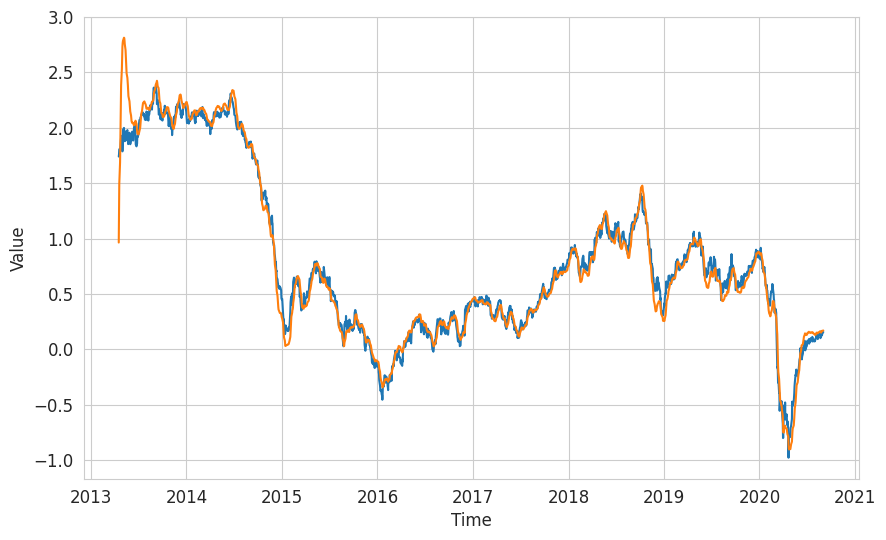

In [28]:
plt.figure(figsize=(10, 6))
plot_series(time=s_val_df.index, series=s_val_df['Close'])
plot_series(time=s_val_df.index, series=val_rnn_forecast)

In [29]:
mae = keras.metrics.MeanAbsoluteError()
mae.update_state(x_valid, val_rnn_forecast)
mae.result().numpy()

0.06665079

In [30]:
mse = keras.metrics.MeanSquaredError()
mse.update_state(x_valid, val_rnn_forecast)
mse.result().numpy()

0.012016152

In [31]:
test_array = np.array(s_test_df['Close'], dtype=np.float32)
test_rnn_forecast = model.predict(test_array[np.newaxis, :, np.newaxis])
test_rnn_forecast = test_rnn_forecast[0, :len(test_array), 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


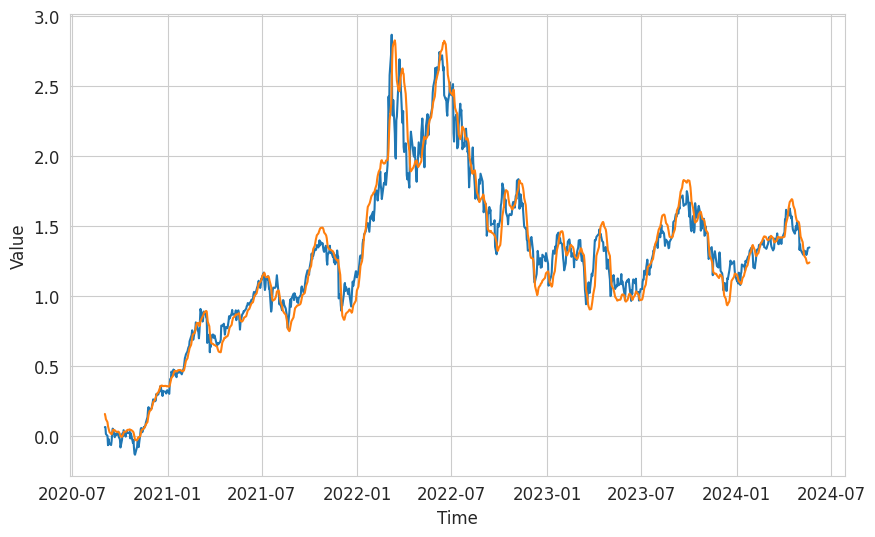

In [32]:
plt.figure(figsize=(10, 6))
plot_series(time=s_test_df.index, series=s_test_df['Close'])
plot_series(time=s_test_df.index, series=test_rnn_forecast)

In [33]:
mae = keras.metrics.MeanAbsoluteError()
mae.update_state(x_test, test_rnn_forecast)
mae.result().numpy()

0.08816663

In [34]:
mse = keras.metrics.MeanSquaredError()
mse.update_state(x_test, test_rnn_forecast)
mse.result().numpy()

0.015273628

In [35]:
df_mean = df.mean()
df_std = df.std()

new_train_df = (df - df_mean) / df_std

len_new_train_df = len(new_train_df)

In [36]:
x_new_train = np.array(new_train_df['Close'], dtype=np.float32)
x_new_train = tf.constant(x_new_train)

In [44]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
new_train_set = sequential_window_dataset(x_new_train, window_size)

model = keras.models.Sequential([
    keras.Input(batch_shape=[1, None, 1]),
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(learning_rate=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanSquaredError()])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint("new_lstm_model.keras", monitor="loss", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", min_delta=3e-4, start_from_epoch=20, patience=10)
model.fit(new_train_set, epochs=500, callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 1.5989 - mean_absolute_error: 2.0203 - mean_squared_error: 9.5532
Epoch 2/500
312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8509 - mean_absolute_error: 1.2065 - mean_squared_error: 3.4585
Epoch 3/500
312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.4953 - mean_absolute_error: 0.8137 - mean_squared_error: 1.5926
Epoch 4/500
312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.3716 - mean_absolute_error: 0.6730 - mean_squared_error: 1.0768
Epoch 5/500
312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.3736 - mean_absolute_error: 0.6648 - mean_squared_error: 1.0877
Epoch 6/500
312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.3832 - mean_absolute_error: 0.6536 - mean_squared_error: 1.1524
Epoch 7/500
312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.3136 - mean_absolute_error: 0.5743 - mean_squared_error: 0.8775
Epoch 8/500
312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.3591 - mean_absolute_error: 0.6002 - mea

In [45]:
model = keras.models.load_model("new_lstm_model.keras", safe_mode=False)